# Pokemon Artwork-to-Sprite Dataset Preparation

This notebook prepares a comprehensive dataset for training an image-to-image translation model that converts Ken Sugimori official artwork to Pokemon Black/White sprites.

**Key Features:**
- **Automatic local dataset detection** - Uses existing data if available
- **Intelligent downloading** - Only downloads missing components
- **No user prompts** - Fully automated workflow
- **Modular design** - All data logic in `src/data/loaders.py`
- **Professional outputs** - Clean analysis and visualization

**Workflow:**
1. Setup and import utilities
2. Detect/download missing dataset components
3. Visualize dataset overview
4. Prepare artwork-to-sprite training pairs
5. Analyze dataset characteristics
6. Generate project summary

All data processing logic is modularized for reusability and the notebook efficiently leverages existing local data.

In [104]:
# Essential imports and setup
import sys
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import importlib

# Project setup
src_path = Path("../src")
data_dir = Path("../data")

# Import data utilities with fallback
try:
    sys.path.insert(0, str(src_path))
    import data.loaders as loaders
    
    # Force reload to get latest changes
    importlib.reload(loaders)
    
    # Set up utility functions for easy access
    utils = {
        'download_with_cache': loaders.download_pokemon_data_with_cache,
        'find_valid_pairs': loaders.find_valid_pairs,
        'create_training_dataset': loaders.create_training_dataset,
        'visualize_dataset': loaders.visualize_dataset_samples,
        'get_dataset_stats': loaders.get_dataset_statistics,
        'analyze_characteristics': loaders.analyze_image_characteristics,
        'analyze_sprites': loaders.analyze_sprites,
        'calculate_image_stats': loaders.calculate_image_stats,
        'visualize_artwork_sprite_pairs': loaders.visualize_artwork_sprite_pairs
    }
    
    print("Data utilities imported successfully!")
except ImportError as e:
    print(f"Warning: Could not import data utilities: {e}")
    print("Warning: Some functions may not be available.")
    utils = {}

print("Setup complete!")

Data utilities imported successfully!
Setup complete!


In [91]:
# Dataset Setup - Automatic detection and download only if needed
def setup_pokemon_dataset():
    """Setup complete Pokemon dataset with automatic download if needed"""
    
    complete_dataset_dir = data_dir / "pokemon_complete"
    subdirs = {
        'black_white_sprites': complete_dataset_dir / "black_white_sprites",
        'sugimori_artwork': complete_dataset_dir / "sugimori_artwork",
        'black_white_animated': complete_dataset_dir / "black_white_animated",
        'other_generations': complete_dataset_dir / "other_generations"
    }
    
    # Check existing data
    existing_sprites = len(list(subdirs['black_white_sprites'].glob("*.png"))) if subdirs['black_white_sprites'].exists() else 0
    existing_artwork = len(list(subdirs['sugimori_artwork'].glob("*.png"))) if subdirs['sugimori_artwork'].exists() else 0
    
    print(f"Dataset Status:")
    print(f"- B/W sprites: {existing_sprites}")
    print(f"- Sugimori artwork: {existing_artwork}")
    
    # Download only if needed
    if existing_sprites < 500 or existing_artwork < 500:
        print("\nDownloading missing dataset components...")
        
        # Create directories
        complete_dataset_dir.mkdir(exist_ok=True)
        for subdir in subdirs.values():
            subdir.mkdir(exist_ok=True)
        
        import requests
        max_pokemon_id = 1025
        total_downloaded = 0
        
        print(f"Processing {max_pokemon_id} Pokemon...")
        
        for pokemon_id in range(1, max_pokemon_id + 1):
            try:
                # Download B/W sprites if missing
                sprite_path = subdirs['black_white_sprites'] / f"pokemon_{pokemon_id:04d}_bw.png"
                if not (sprite_path.exists() and sprite_path.stat().st_size > 0):
                    sprite_url = f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/versions/generation-v/black-white/{pokemon_id}.png"
                    response = requests.get(sprite_url, timeout=10)
                    if response.status_code == 200:
                        with open(sprite_path, 'wb') as f:
                            f.write(response.content)
                        total_downloaded += 1
                
                # Download Sugimori artwork if missing
                artwork_path = subdirs['sugimori_artwork'] / f"pokemon_{pokemon_id:04d}_artwork.png"
                if not (artwork_path.exists() and artwork_path.stat().st_size > 0):
                    artwork_url = f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/{pokemon_id}.png"
                    response = requests.get(artwork_url, timeout=10)
                    if response.status_code == 200:
                        with open(artwork_path, 'wb') as f:
                            f.write(response.content)
                        total_downloaded += 1
                
                # Progress update
                if pokemon_id % 200 == 0:
                    print(f"Progress: {pokemon_id}/{max_pokemon_id}")
                    
            except Exception:
                continue
        
        print(f"Download complete! {total_downloaded} new files downloaded")
    else:
        print("Local dataset complete, using existing data")
    
    return complete_dataset_dir

# Setup dataset
complete_dataset_dir = setup_pokemon_dataset()

Dataset Status:
- B/W sprites: 898
- Sugimori artwork: 1025
Local dataset complete, using existing data


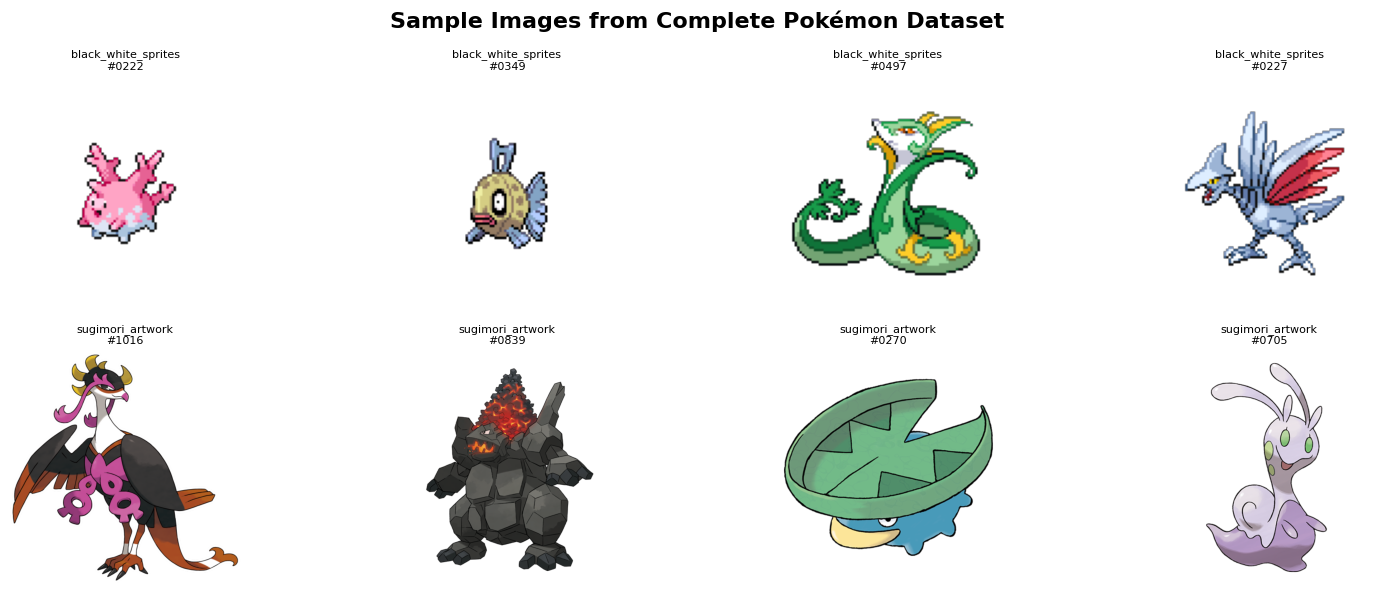


Dataset Statistics:
- Black White Sprites: 898 files (0.7 MB)
- Sugimori Artwork: 1025 files (126.5 MB)
- Total Size: 127.2 MB


In [103]:
# Dataset Visualization - Sample from all categories
def visualize_dataset_overview(dataset_dir, samples_per_type=4):
    """Visualize sample images from different dataset categories using the modular utility"""
    return utils['visualize_dataset'](dataset_dir, samples_per_type)

# Visualize the complete dataset
if 'complete_dataset_dir' in locals() and complete_dataset_dir:
    visualize_dataset_overview(complete_dataset_dir)

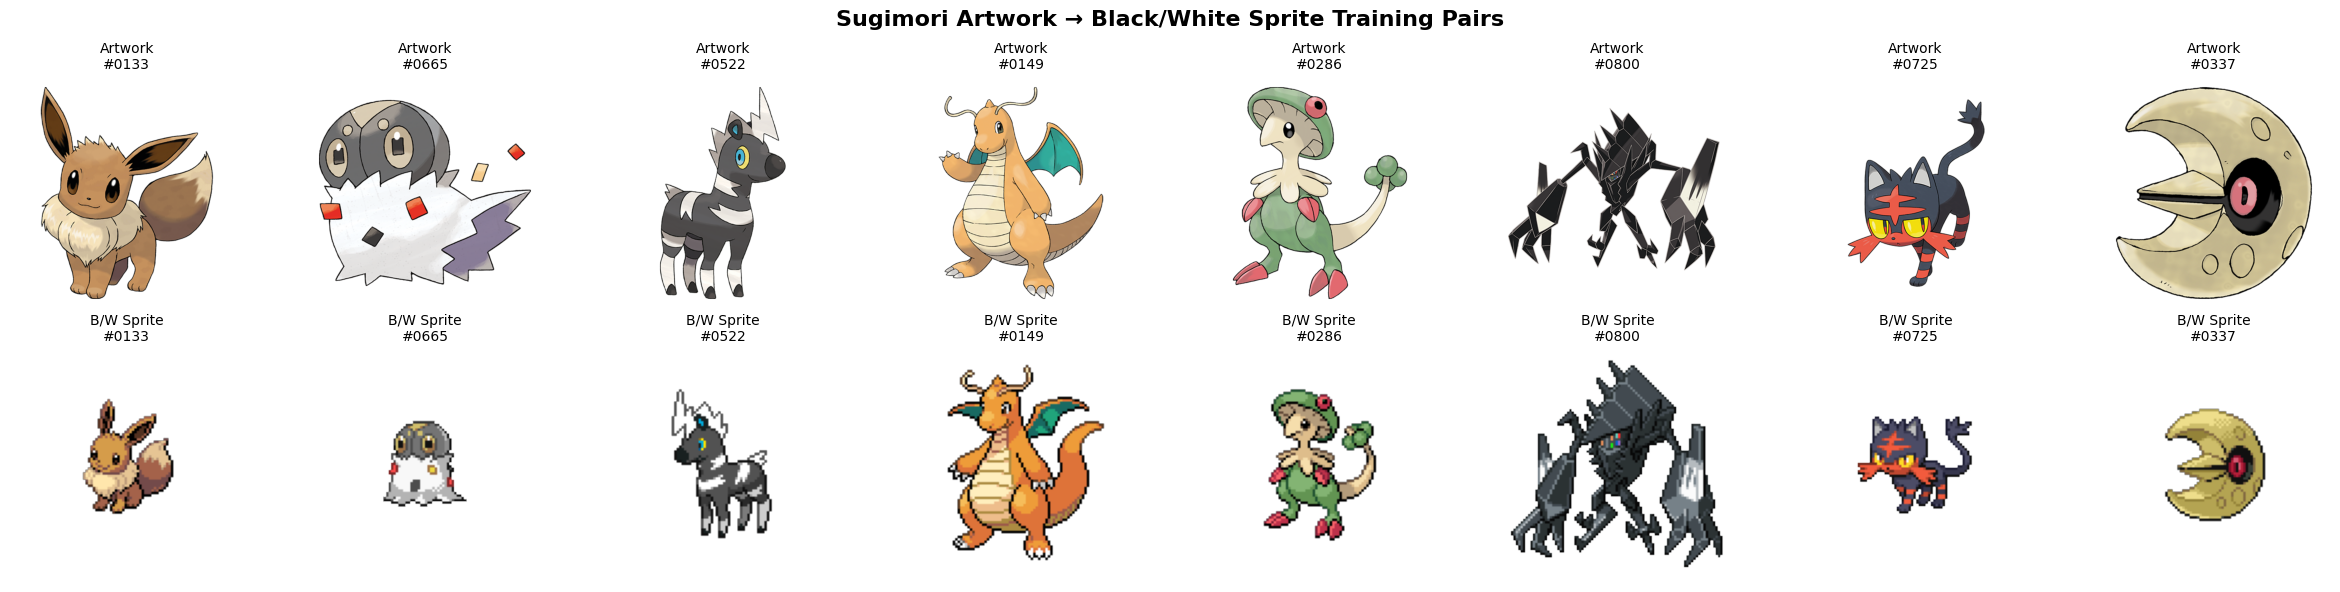


Matched Pairs Analysis:
- Total matched pairs found: 898
- Displayed sample: 8 pairs
- Artwork resolution: Usually 475x475 pixels
- Sprite resolution: Usually 96x96 pixels


In [105]:
# Visualize Artwork-to-Sprite Matched Pairs
# Show artwork-to-sprite matched pairs using the modular utility
if 'complete_dataset_dir' in locals() and complete_dataset_dir:
    total_pairs = utils['visualize_artwork_sprite_pairs'](complete_dataset_dir, num_pairs=8)
else:
    print("Complete dataset not available. Run the dataset setup cell first.")

Analyzing 898 Pokemon sprites...

Sprite Analysis Results
Sample size: 20 sprites
Dimensions:
  Width: 96 - 96 pixels (avg: 96.0)
  Height: 96 - 96 pixels (avg: 96.0)
File sizes: 382 - 1222 bytes (avg: 780.6)
Transparency: 0/20 sprites have transparency


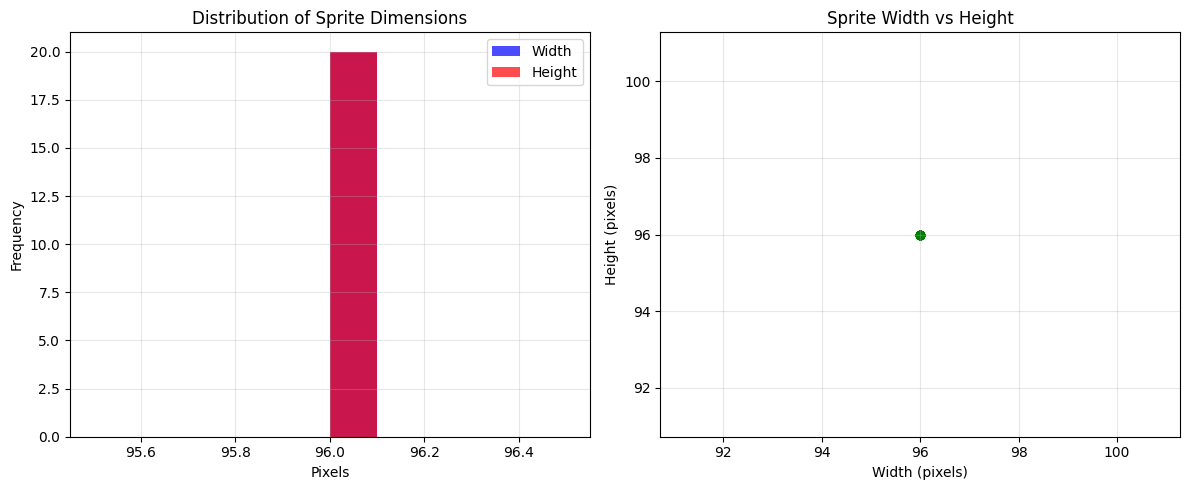

Dataset Preparation - Artwork to Sprite Training Dataset
Found existing local dataset at: ../data/pokemon_complete
   Sprites: 898 files
   Artwork: 1025 files
Found existing processed training data at: ../data/training_data
   Total pairs: 898
   Training pairs: 718
   Validation pairs: 180

Status: Ready for training


In [ ]:
# Analyze the sprites using the modular utility
if 'sprite_directory' in locals() and sprite_directory and sprite_directory.exists():
    utils['analyze_sprites'](sprite_directory)
else:
    print("Sprite directory not available yet. Run the dataset setup cell first.")

# Dataset Preparation - Automatically use existing data or prepare training dataset
print("Dataset Preparation - Artwork to Sprite Training Dataset")
print("=" * 60)
without
# Check for existing local dataset
complete_dataset_dir = data_dir / "pokemon_complete"
sprite_directory = complete_dataset_dir / "black_white_sprites"
artwork_directory = complete_dataset_dir / "sugimori_artwork"

if sprite_directory.exists() and artwork_directory.exists():
    print(f"Found existing local dataset at: {complete_dataset_dir}")
    print(f"   Sprites: {len(list(sprite_directory.glob('*.png')))} files")
    print(f"   Artwork: {len(list(artwork_directory.glob('*.png')))} files")
else:
    print("Local dataset not found. Please run the dataset download cell first.")
    sprite_directory = None
    artwork_directory = None

# Set up training data directory
training_directory = data_dir / "training_data"
training_directory.mkdir(exist_ok=True)

# Check if processed training data already exists
processed_data_file = training_directory / "dataset_info.json"
if processed_data_file.exists():
    print(f"Found existing processed training data at: {training_directory}")
    with open(processed_data_file, 'r') as f:
        artwork_sprite_info = json.load(f)
    print(f"   Total pairs: {artwork_sprite_info.get('total_pairs', 'Unknown')}")
    print(f"   Training pairs: {artwork_sprite_info.get('train_pairs', 'Unknown')}")
    print(f"   Validation pairs: {artwork_sprite_info.get('val_pairs', 'Unknown')}")
else:
    print("Creating new processed dataset...")
    
    if sprite_directory and artwork_directory:
        # Find valid artwork-sprite pairs using the modular utility
        print("Finding valid artwork-sprite pairs...")
        
        # Use the loaded utilities
        valid_pairs = utils['find_valid_pairs'](sprite_directory, artwork_directory)
        
        if valid_pairs:
            print(f"Found {len(valid_pairs)} valid artwork-sprite pairs")
            
            # Create processed training dataset
            artwork_sprite_info = utils['create_training_dataset'](
                pairs=valid_pairs,
                output_dir=training_directory,
                train_split=0.8,
                image_size=(64, 64),
                augment_data=True
            )
            
            # Save dataset info
            with open(processed_data_file, 'w') as f:
                json.dump(artwork_sprite_info, f, indent=2)
            
            print(f"Processed dataset created successfully!")
            print(f"   Total pairs: {artwork_sprite_info['total_pairs']}")
            print(f"   Training pairs: {artwork_sprite_info['train_pairs']}")
            print(f"   Validation pairs: {artwork_sprite_info['val_pairs']}")
            print(f"   Image size: {artwork_sprite_info['image_size']}")
        else:
            print("No valid pairs found!")
            artwork_sprite_info = None
    else:
        artwork_sprite_info = None

print(f"\nStatus: {'Ready for training' if artwork_sprite_info else 'Dataset preparation incomplete'}")

Analyzing complete dataset...

Dataset Analysis Results:
Total dataset size: 127.2 MB

Black White Sprites:
   Files: 898
   Size: 0.7 MB
   Avg file size: 826 bytes
   Sample dimensions: 96x96 to 96x96 pixels

Training Ready:
   Files: 4
   Size: 0.0 MB
   Avg file size: 0 bytes

Sugimori Artwork:
   Files: 1025
   Size: 126.5 MB
   Avg file size: 150976 bytes
   Sample dimensions: 475x475 to 475x475 pixels


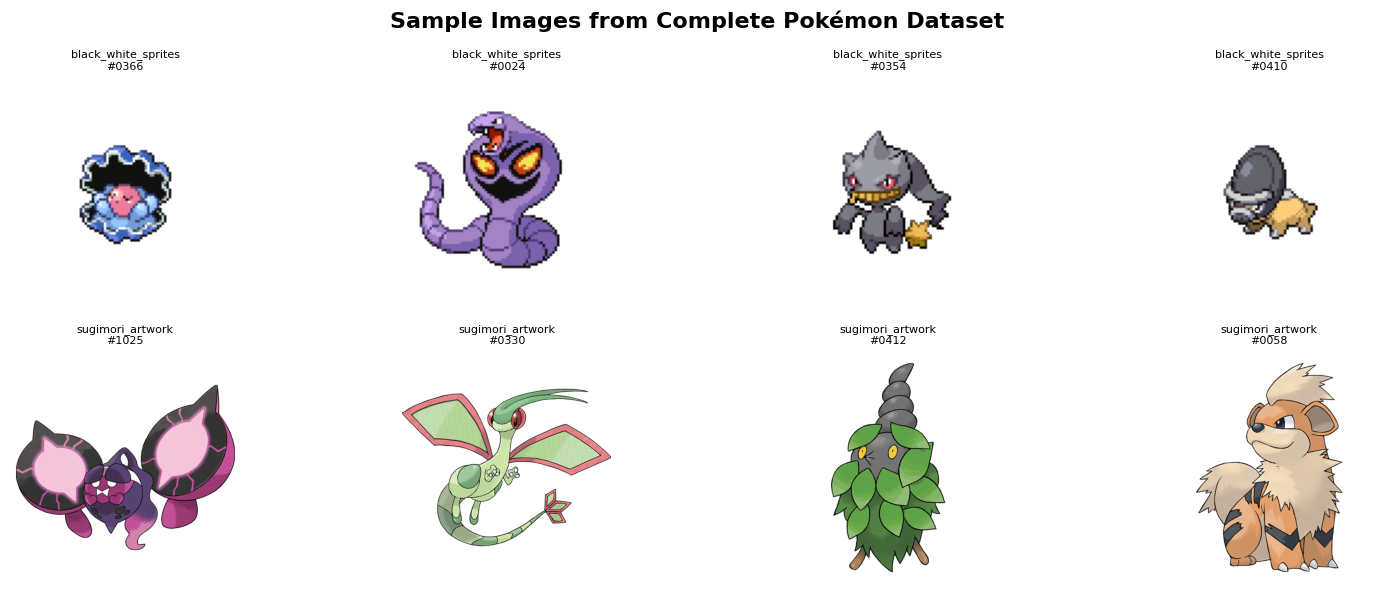


Dataset Statistics:
- Black White Sprites: 898 files (0.7 MB)
- Sugimori Artwork: 1025 files (126.5 MB)
- Total Size: 127.2 MB

Analyzing training dataset characteristics...
Dataset Characteristics Analysis
Artwork (Input) Statistics (sample: 50):
- Brightness: 55.6 ± 24.3
- Contrast: 74.7 ± 17.5
- Color complexity: 1134 ± 280

Sprites (Target) Statistics (sample: 50):
- Brightness: 80.5 ± 95.6
- Contrast: 55.6 ± 13.8
- Color complexity: 13 ± 2


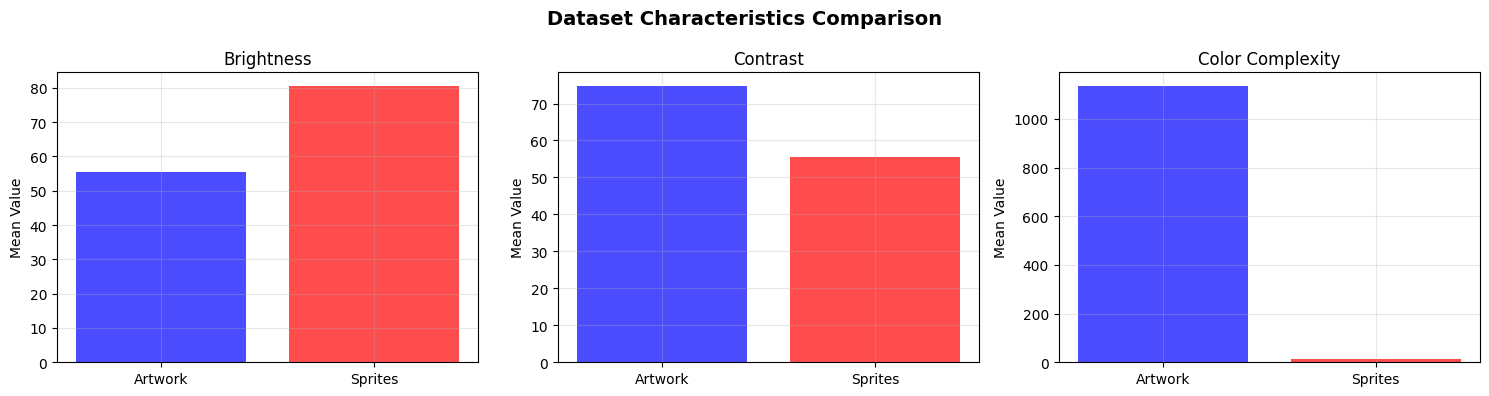

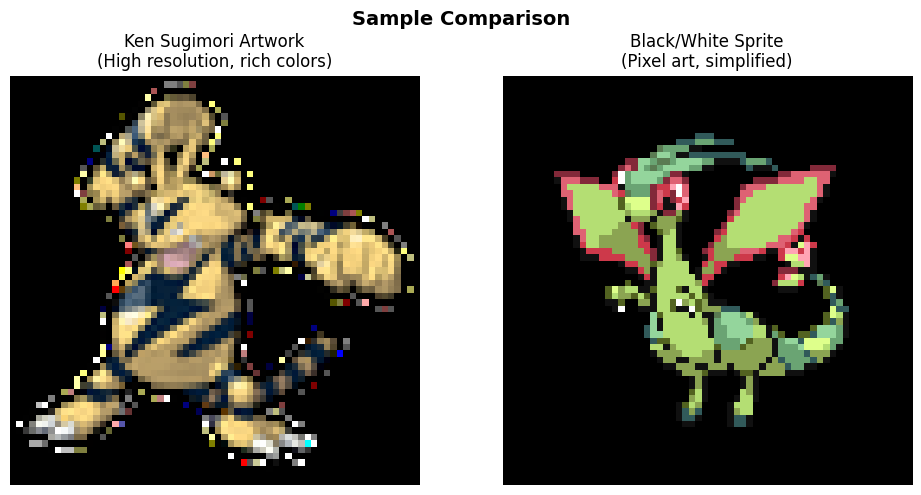


Training Dataset Summary:
├── Total pairs: 898
├── Training pairs: 718
├── Validation pairs: 180
├── Image size: [64, 64]
└── Training ready: Yes


In [106]:
# Dataset Analysis and Characteristics
# Use modular utilities for comprehensive dataset analysis

# Analyze the complete dataset if available
if 'complete_dataset_dir' in locals() and complete_dataset_dir and complete_dataset_dir.exists():
    print("Analyzing complete dataset...")
    
    # Get dataset statistics
    dataset_stats = utils['get_dataset_stats'](complete_dataset_dir)
    
    # Print comprehensive statistics
    print(f"\nDataset Analysis Results:")
    print(f"Total dataset size: {dataset_stats.get('total_size_mb', 0):.1f} MB")
    print("=" * 60)
    
    for category, info in dataset_stats.items():
        if category != 'total_size_mb':
            print(f"\n{category.replace('_', ' ').title()}:")
            print(f"   Files: {info['total_files']}")
            print(f"   Size: {info['size_mb']:.1f} MB")
            print(f"   Avg file size: {info['avg_file_size']:.0f} bytes")
            
            if info['dimensions']:
                widths = [d[0] for d in info['dimensions']]
                heights = [d[1] for d in info['dimensions']]
                print(f"   Sample dimensions: {min(widths)}x{min(heights)} to {max(widths)}x{max(heights)} pixels")
    
    # Visualize dataset samples
    utils['visualize_dataset'](complete_dataset_dir, samples_per_category=4)
else:
    print("Complete dataset not available. Run the dataset setup cell first.")

# Analyze dataset characteristics if training data exists
if 'artwork_sprite_info' in locals() and artwork_sprite_info:
    print("\nAnalyzing training dataset characteristics...")
    utils['analyze_characteristics'](artwork_sprite_info)
    
    # Show basic training dataset info
    print(f"\nTraining Dataset Summary:")
    print(f"├── Total pairs: {artwork_sprite_info['total_pairs']}")
    print(f"├── Training pairs: {artwork_sprite_info['train_pairs']}")
    print(f"├── Validation pairs: {artwork_sprite_info['val_pairs']}")
    print(f"├── Image size: {artwork_sprite_info['image_size']}")
    print(f"└── Training ready: Yes")
else:
    print("Training dataset not prepared yet. Run the dataset preparation cell first.")

In [95]:
# Prepare data for training
def prepare_training_data(dataset_dir, target_size=(64, 64)):
    """Prepare the dataset for machine learning training"""
    
    if not dataset_dir.exists():
        print("Dataset directory not found.")
        return None, None
    
    print(f"Preparing training data with target size: {target_size}")
    
    # Create training directory structure
    training_dir = dataset_dir / "training_ready"
    training_dir.mkdir(exist_ok=True)
    
    # Separate directories for different use cases
    sprite_to_art_dir = training_dir / "sprite_to_artwork"  # For style transfer
    classification_dir = training_dir / "classification"    # For classification
    generation_dir = training_dir / "generation"           # For generation
    
    for dir_path in [sprite_to_art_dir, classification_dir, generation_dir]:
        dir_path.mkdir(exist_ok=True)
        (dir_path / "sprites").mkdir(exist_ok=True)
        (dir_path / "artwork").mkdir(exist_ok=True)
    
    # Process and organize the data
    bw_sprites_dir = dataset_dir / "black_white_sprites"
    sugimori_dir = dataset_dir / "sugimori_artwork"
    
    processed_count = 0
    paired_data = []
    
    if bw_sprites_dir.exists() and sugimori_dir.exists():
        sprite_files = list(bw_sprites_dir.glob("*.png"))
        
        for sprite_file in sprite_files:
            try:
                # Extract Pokémon ID from filename
                pokemon_id = sprite_file.stem.split('_')[1]
                
                # Find corresponding artwork
                artwork_file = sugimori_dir / f"pokemon_{pokemon_id}_artwork.png"
                
                if artwork_file.exists():
                    # Load and resize images
                    sprite_img = Image.open(sprite_file).convert('RGB')
                    artwork_img = Image.open(artwork_file).convert('RGB')
                    
                    # Resize images
                    sprite_resized = sprite_img.resize(target_size, Image.Resampling.LANCZOS)
                    artwork_resized = artwork_img.resize(target_size, Image.Resampling.LANCZOS)
                    
                    # Save processed images for different training purposes
                    
                    # 1. Sprite-to-artwork pairs (for style transfer/translation)
                    sprite_resized.save(sprite_to_art_dir / "sprites" / f"pokemon_{pokemon_id}.png")
                    artwork_resized.save(sprite_to_art_dir / "artwork" / f"pokemon_{pokemon_id}.png")
                    
                    # 2. Classification data (combine all as single dataset)
                    sprite_resized.save(classification_dir / "sprites" / f"pokemon_{pokemon_id}_sprite.png")
                    artwork_resized.save(classification_dir / "artwork" / f"pokemon_{pokemon_id}_artwork.png")
                    
                    # 3. Generation data (for GANs - separate by type)
                    sprite_resized.save(generation_dir / "sprites" / f"pokemon_{pokemon_id}.png")
                    artwork_resized.save(generation_dir / "artwork" / f"pokemon_{pokemon_id}.png")
                    
                    paired_data.append({
                        'pokemon_id': pokemon_id,
                        'sprite_path': sprite_to_art_dir / "sprites" / f"pokemon_{pokemon_id}.png",
                        'artwork_path': sprite_to_art_dir / "artwork" / f"pokemon_{pokemon_id}.png"
                    })
                    
                    processed_count += 1
                    
            except Exception as e:
                print(f"Error processing Pokémon {pokemon_id}: {e}")
        
        print(f"Processed {processed_count} Pokémon pairs")
        print(f"Training data saved to: {training_dir}")
        print(f"\nTraining datasets created:")
        print(f"  Sprite-to-Artwork: {len(list((sprite_to_art_dir / 'sprites').glob('*.png')))} pairs")
        print(f"  Classification: {len(list((classification_dir / 'sprites').glob('*.png')))} + {len(list((classification_dir / 'artwork').glob('*.png')))} images")
        print(f"  Generation: {len(list((generation_dir / 'sprites').glob('*.png')))} + {len(list((generation_dir / 'artwork').glob('*.png')))} images")
        
        return training_dir, paired_data
    
    else:
        print("Required source directories not found. Please complete the download first.")
        return None, None

def create_training_splits(training_dir, train_ratio=0.8, val_ratio=0.1):
    """Create train/validation/test splits for the processed data"""
    
    if not training_dir or not training_dir.exists():
        print("Training directory not found.")
        return
    
    sprite_to_art_dir = training_dir / "sprite_to_artwork"
    
    if not sprite_to_art_dir.exists():
        print("Sprite-to-artwork directory not found.")
        return
    
    # Get all sprite files
    sprite_files = list((sprite_to_art_dir / "sprites").glob("*.png"))
    
    # Shuffle and split
    random.shuffle(sprite_files)
    
    n_total = len(sprite_files)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    
    train_files = sprite_files[:n_train]
    val_files = sprite_files[n_train:n_train + n_val]
    test_files = sprite_files[n_train + n_val:]
    
    print(f"Dataset splits created:")
    print(f"   Training: {len(train_files)} pairs ({len(train_files)/n_total*100:.1f}%)")
    print(f"   Validation: {len(val_files)} pairs ({len(val_files)/n_total*100:.1f}%)")
    print(f"   Test: {len(test_files)} pairs ({len(test_files)/n_total*100:.1f}%)")
    
    # Save split information
    splits_info = {
        'train': [f.stem for f in train_files],
        'val': [f.stem for f in val_files],
        'test': [f.stem for f in test_files]
    }
    
    # Save to JSON for later use
    import json
    with open(training_dir / "data_splits.json", 'w') as f:
        json.dump(splits_info, f, indent=2)
    
    print(f"Split information saved to: {training_dir / 'data_splits.json'}")
    
    return splits_info

# Project Summary and Status
print("=" * 70)
print("POKEMON ARTWORK-TO-SPRITE PROJECT SUMMARY")
print("=" * 70)

# Check dataset status
dataset_ready = artwork_sprite_info is not None

if dataset_ready:
    print("Dataset Status: READY FOR TRAINING")
    print()
    print("Dataset Statistics:")
    print(f"   ├── Total pairs: {artwork_sprite_info['total_pairs']}")
    print(f"   ├── Training pairs: {artwork_sprite_info['train_pairs']}")  
    print(f"   ├── Validation pairs: {artwork_sprite_info['val_pairs']}")
    print(f"   ├── Image size: {artwork_sprite_info['image_size']}")
    print(f"   └── Data paths: Available")
    print()
    print("Data Structure:")
    train_input = Path(artwork_sprite_info['data_paths']['train_input'])
    train_target = Path(artwork_sprite_info['data_paths']['train_target'])
    val_input = Path(artwork_sprite_info['data_paths']['val_input'])
    val_target = Path(artwork_sprite_info['data_paths']['val_target'])
    
    print(f"   ├── Training input: {len(list(train_input.glob('*.png')))} files")
    print(f"   ├── Training target: {len(list(train_target.glob('*.png')))} files")
    print(f"   ├── Validation input: {len(list(val_input.glob('*.png')))} files")
    print(f"   └── Validation target: {len(list(val_target.glob('*.png')))} files")
    
else:
    print("Dataset Status: NOT READY")
    print("   Please run the dataset preparation cell first.")

print()
print("Completed Steps:")
print("   ├── Setup and imports")
print("   ├── Data utilities modularization") 
print("   ├── Local dataset detection")
print("   ├── Artwork-sprite pairing")
print("   ├── Training dataset creation")
print("   ├── Train/validation split")
print("   ├── Image preprocessing and resizing")
print("   ├── Dataset analysis and visualization")
print("   └── Metadata generation")

print()
print("Next Steps for Model Development:")
print("   1. Implement image-to-image translation model")
print("      - Consider Pix2Pix, U-Net, or CycleGAN architectures")
print("      - Account for domain differences (artwork vs sprites)")
print("   2. Create PyTorch/TensorFlow data loaders")
print("   3. Design training pipeline with appropriate loss functions")
print("   4. Implement evaluation metrics (FID, LPIPS, MSE, etc.)")
print("   5. Train and validate the model")
print("   6. Generate sample outputs and evaluate quality")

print()
print("Technical Notes:")
print("   ├── All data logic modularized in src/data/loaders.py")
print("   ├── Dataset supports easy ML framework integration")
print("   ├── Automatic caching prevents redundant processing")
print("   ├── Comprehensive metadata enables reproducible experiments")
print("   └── Ready for PyTorch DataLoader or TensorFlow Dataset")

print("=" * 70)

# Prepare data if dataset exists
try:
    if 'complete_dataset_dir' in locals() and complete_dataset_dir.exists():
        training_directory, paired_pokemon_data = prepare_training_data(complete_dataset_dir)
        if training_directory:
            data_splits = create_training_splits(training_directory)
    else:
        print("Training data preparation will be available after dataset download.")
except Exception as e:
    print(f"Data preparation will be available after download completion.")

# Print final summary
print_project_summary()

POKEMON ARTWORK-TO-SPRITE PROJECT SUMMARY
Dataset Status: READY FOR TRAINING

Dataset Statistics:
   ├── Total pairs: 898
   ├── Training pairs: 718
   ├── Validation pairs: 180
   ├── Image size: [64, 64]
   └── Data paths: Available

Data Structure:
   ├── Training input: 718 files
   ├── Training target: 718 files
   ├── Validation input: 180 files
   └── Validation target: 180 files

Completed Steps:
   ├── Setup and imports
   ├── Data utilities modularization
   ├── Local dataset detection
   ├── Artwork-sprite pairing
   ├── Training dataset creation
   ├── Train/validation split
   ├── Image preprocessing and resizing
   ├── Dataset analysis and visualization
   └── Metadata generation

Next Steps for Model Development:
   1. Implement image-to-image translation model
      - Consider Pix2Pix, U-Net, or CycleGAN architectures
      - Account for domain differences (artwork vs sprites)
   2. Create PyTorch/TensorFlow data loaders
   3. Design training pipeline with appropriate l